# Final Project for Data Analytics

## Alyssa June Pacleb, Ravi Goparaju, Adeena Amersi, Ryan Chiapoco

We are trying to predict the political party subjects donate to given their occupation, donation amount, election phase, and year.

In [95]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import sklearn.preprocessing as preproc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

%matplotlib inline

# Science Giving Column Meanings and Types

Column Name | Definition | Type
---|---------|-------|
`cmte_nm` | Committee name | object
`cmte_id` | Committee identification, assigned | object
`cmte_tp` | Committee type. [List of committee type codes](https://www.fec.gov/campaign-finance-data/committee-type-code-descriptions/)  | object
<font size="5">**`cmte_pty`**</font>  | **Committee party. [List of party codes](https://www.fec.gov/campaign-finance-data/party-code-descriptions/)** | **object**
`cand_name` | Candidate name | object
`cand_pty_affiliation` | Political party affiliation reported by the candidate | object
`cand_office_st` | Candidate state | object
<font size="5">**`cand_office`**</font>  | Candidate office. H = House, P = President, S = Senate | object
`cand_office_district` | Candidate district | float64
`cand_status` | Candidate status. C = Statutory candidate, F = Statutory candidate for future election, N = Not yet a statutory candidate, P = Statutory candidate in prior cycle | object
`rpt_tp` | Report type. [Report type codes](https://www.fec.gov/campaign-finance-data/report-type-code-descriptions/) | object
<font size="5">**`transaction_pgi`**</font> | The code for which the contribution was made. EYYYY (election plus election year). P = Primary, G = General, O = Other, C = Convention, R = Runoff, S = Special, E = Recount | object
`transaction_tp` | Transaction type. [Type codes](https://www.fec.gov/campaign-finance-data/transaction-type-code-descriptions/) | object
`entity_tp` | Entity type. Only valid for electronic filings received after April 2002. CAN = Candidate, CCM = Candidate Committee, COM = Committee, IND = Individual (a person), ORG = Organization (not a committee and not a person), PAC = Political Action Committee, PTY = Party Organization | object
`cleaned_name` | Contributor/lender/transfer name | object
`city` | City/town | object
`state`** | State | object
`zip_code` | Zip code | object
`employer` | Employer | object
`cleaned_occupation`| Occupation | object
<font size="5">**`classification`**</font>  | Classification of occupation | object
`transaction_dt` | Transaction date (MMDDYYYY) | float64
<font size="5">**`cycle`**</font> | Election cycle | float64
`transaction_amt` | Transaction amount | float64
<font size="5">**`2016_dollars`**</font>  | Transation amount adjusted for inflation | float64
`other_id` | Other identification number. For contributions from individuals this column is null. For contributions from candidates or other committees this column will contain that contributor's FEC ID. | object
`tran_id` | Transaction ID | object
`file_num` | A unique identifier associated with each itemization or transaction appearing in an FEC electronic file. Only valid for electronic filings. | float64
`memo_cd` | 'X' indicates that the amount is not to be included in the itemization total. | object
`memo_text` | A description of the activity. | object
`sub_id` | FEC record number | float64

# Data Preparation and Feature Engineering

In [45]:
url = 'https://media.githubusercontent.com/media/fivethirtyeight/data/master/science-giving/science_federal_giving.csv'
df = pd.read_csv(url, error_bad_lines=False)

In [46]:
print(df.shape)
df.head()

(881793, 31)


,cmte_nm,cmte_id,cmte_tp,cmte_pty,cand_name,cand_pty_affiliation,cand_office_st,cand_office,cand_office_district,cand_status,...,transaction_dt,cycle,transaction_amt,2016_dollars,other_id,tran_id,file_num,memo_cd,memo_text,sub_id
0,AMERICAN WAY - DURANT 2012; THE,C00501452,S,REP,"DURANT, CLARK",REP,MI,S,0.0,C,...,3302012.0,2012.0,2500.0,2612.50,NaN,SA0108160812336,845273.0,NaN,NaN,1.010000e+18
1,A LOT OF PEOPLE FOR DAVE OBEY,C00017830,H,DEM,"OBEY, DAVID R",DEM,WI,H,7.0,C,...,4182007.0,2008.0,250.0,292.50,NaN,C34559,294636.0,NaN,NaN,4.070000e+18
2,A WHOLE LOT OF PEOPLE FOR GRIJALVA CONGRESSION...,C00374058,H,DEM,"GRIJALVA, RAUL M",DEM,AZ,H,3.0,C,...,6092016.0,2016.0,50.0,50.00,C00401224,VSH8VCDY4S4,1096417.0,NaN,* EARMARKED CONTRIBUTION: SEE BELOW,4.080000e+18
3,A WHOLE LOT OF PEOPLE FOR GRIJALVA CONGRESSION...,C00374058,H,DEM,"GRIJALVA, RAUL M",DEM,AZ,H,3.0,C,...,8192012.0,2012.0,2500.0,2612.50,NaN,C6548162,863428.0,NaN,NaN,4.030000e+18
4,A WHOLE LOT OF PEOPLE FOR GRIJALVA CONGRESSION...,C00374058,H,DEM,"GRIJALVA, RAUL M",DEM,AZ,H,7.0,C,...,10292010.0,2010.0,250.0,273.25,NaN,C5156783,863417.0,NaN,NaN,4.030000e+18


In [47]:
print(df.isna().sum()) # Clearly there is a bit of an issue here

cmte_nm                 411590
cmte_id                 411590
cmte_tp                 411590
cmte_pty                411796
cand_name               497992
cand_pty_affiliation    497997
cand_office_st          497992
cand_office             497992
cand_office_district    498030
cand_status             498076
rpt_tp                  411590
transaction_pgi         451317
transaction_tp          411590
entity_tp               411636
cleaned_name            411616
city                    411668
state                   412250
zip_code                412151
employer                413929
cleanedoccupation       411590
classification          411590
transaction_dt          411597
cycle                   411597
transaction_amt         411590
2016_dollars            411619
other_id                783423
tran_id                 411590
file_num                411590
memo_cd                 878451
memo_text               697623
sub_id                  411590
dtype: int64


In [48]:
# We don't care about these features because they don't give us additional information and they are redundant.
new = df.drop(columns=['cand_pty_affiliation', 'state',"cand_office",'cand_name', 'cleanedoccupation','cand_office_st', 'cleaned_name','employer','cmte_nm', 'cmte_id' , 'cmte_tp', 'cand_office_district', 'transaction_amt', 'cand_status', 'rpt_tp', 'transaction_tp', 'tran_id', 'file_num', 'memo_cd', 'memo_text', 'sub_id', 'other_id', 'zip_code', "cand_name", 'entity_tp', 'city','transaction_dt'])

# We only want to look at the general presidential election donations
new = new[(new['cmte_pty'] == 'DEM') | (new['cmte_pty'] == 'REP')]

# Keep only General and Primary election values in the transaction_pgi column
new = new[(new['transaction_pgi'] == 'G') | (new['transaction_pgi'] == 'P')]

new['cmte_pty'].replace(to_replace = 'dem', value = 'DEM', inplace = True)
new['cmte_pty'].replace(to_replace = 'Dem', value = 'DEM', inplace = True)

# Standardize the label of the Republican party
new['cmte_pty'].replace(to_replace = 'rep', value = 'REP', inplace = True)
new['cmte_pty'].replace(to_replace = 'Rep', value = 'REP', inplace = True)

new = new.dropna()
new['cycle'] = new['cycle'].astype(int)
print(new.isna().sum()) 
print(new.shape)
new.head()

cmte_pty           0
transaction_pgi    0
classification     0
cycle              0
2016_dollars       0
dtype: int64
(422393, 5)


,cmte_pty,transaction_pgi,classification,cycle,2016_dollars
0,REP,P,Engineer,2012,2612.50
1,DEM,P,Engineer,2008,292.50
2,DEM,P,Engineer,2016,50.00
3,DEM,P,Engineer,2012,2612.50
4,DEM,G,Scientist,2010,273.25


In [49]:
print(new['cmte_pty'].value_counts())
print(new.shape)

DEM    321200
REP    101193
Name: cmte_pty, dtype: int64
(422393, 5)


# Data Exploration

We found that the two major parties were the Democratic and Republican parties. We used `seaborn` package to view our categorical variables with heat maps. We found that approximately 75% of donations were to the Democratic party while 25% were to the Republican party. Primary elections resulted in the most donations while engineers was the group that donated over other occupation groups. 

The median donation value to the Republican party was larger than that of the Democratic party, $50 and $253.50 respectively. The majority of the donations were below $500.


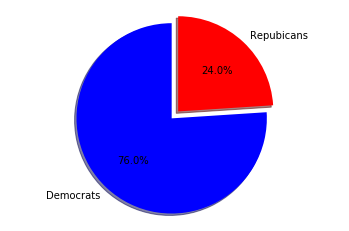

[Text(0, 0, 'Democrat'), Text(0, 0, 'Republican')]

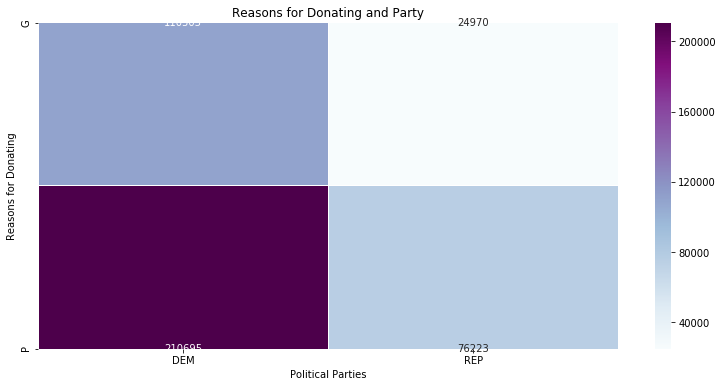

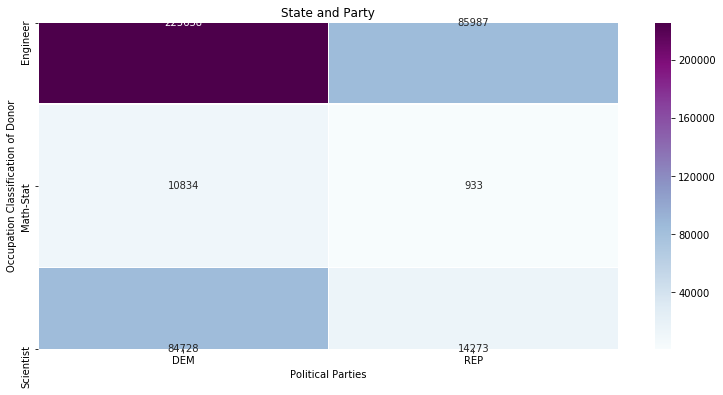

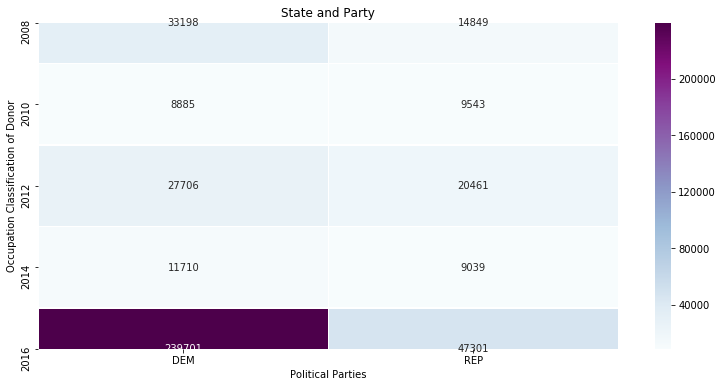

<Figure size 432x288 with 0 Axes>

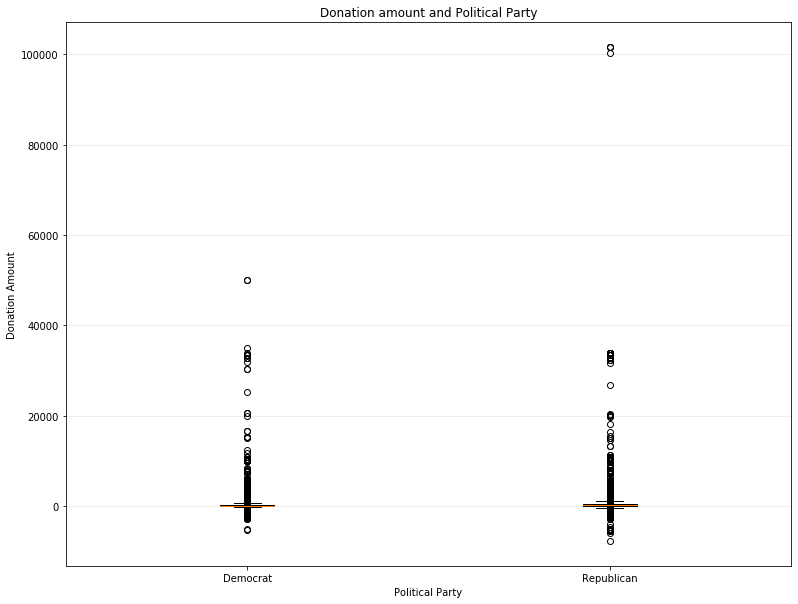

In [50]:
import seaborn as sns

dem_percentage = 320692/421803*100 #ew oh well
rep_percentage = 101111/421803*100

dem = new[new['cmte_pty'] == 'DEM']
rep = new[new['cmte_pty'] == 'REP']
lib = new[new['cmte_pty'] == 'LIB']

ticklabels = ['Democrat', 'Republican']

colors = ["blue", "red"]

# 1 cmte_pty
labels = 'Democrats', 'Repubicans'
sizes = [dem_percentage, rep_percentage]
explode = (0, 0.1)  # only "explode" the 2nd slice
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, colors = colors)
ax1.axis('equal') 
plt.show()

# 2 transaction_pgi
state_graph = new.groupby(['transaction_pgi','cmte_pty']).size().reset_index(name='counts')
state_piv = state_graph.pivot("transaction_pgi", "cmte_pty", "counts")
state_piv = state_piv.replace(np.nan, 0) 
fig2, ax2 = plt.subplots(figsize=(13, 6))
sns.heatmap(state_piv, annot=True, linewidths=.5, ax=ax2, cmap='BuPu',fmt='g')
ax2.axes.set_title("Reasons for Donating and Party");
ax2.axes.set_xlabel('Political Parties')
ax2.axes.set_ylabel('Reasons for Donating')

# 3 classification
occupation_graph = new.groupby(['classification','cmte_pty']).size().reset_index(name='counts')
occupation_piv = occupation_graph.pivot("classification", "cmte_pty", "counts")
occupation_piv = occupation_piv.replace(np.nan, 0) 
fig3, ax3 = plt.subplots(figsize=(13, 6))
sns.heatmap(occupation_piv, annot=True, linewidths=.5, ax=ax3, cmap='BuPu',fmt='g')
ax3.axes.set_title("State and Party");
ax3.axes.set_xlabel('Political Parties')
ax3.axes.set_ylabel('Occupation Classification of Donor')

# 4 cycle
cycle_graph = new.groupby(['cycle','cmte_pty']).size().reset_index(name='counts')
cycle_piv = cycle_graph.pivot("cycle", "cmte_pty", "counts")
cycle_piv = cycle_piv.replace(np.nan, 0) 
fig5, ax5 = plt.subplots(figsize=(13, 6))
sns.heatmap(cycle_piv, annot=True, linewidths=.5, ax=ax5, cmap='BuPu',fmt='g')
ax5.axes.set_title("State and Party");
ax5.axes.set_xlabel('Political Parties')
ax5.axes.set_ylabel('Occupation Classification of Donor')

# 5 2016_dollars
plt.figure()
fig6, ax6 = plt.subplots(figsize=(13, 10))
ax6.set_title('Donation amount and Political Party')
ax6.set_xlabel('Political Party')
ax6.set_ylabel('Donation Amount')
ax6.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
ax6.boxplot([dem['2016_dollars'], rep['2016_dollars']])
ax6.set_xticklabels(ticklabels)

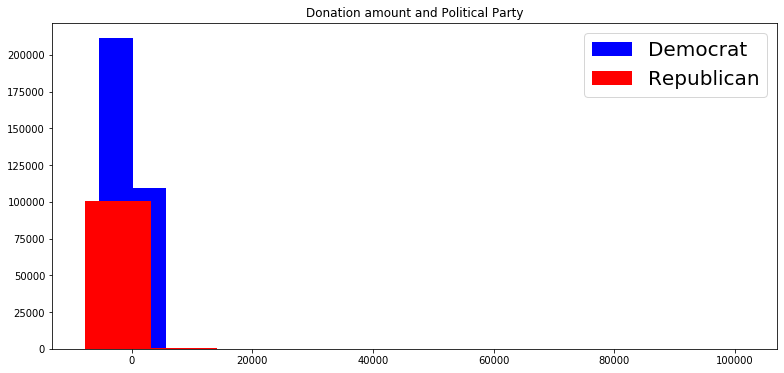

In [51]:
fig7, ax7 = plt.subplots(figsize=(13, 6))
ax7.set_title('Donation amount and Political Party')
ax7.hist(new['2016_dollars'][new['cmte_pty'] == "DEM"], color = "blue", label = "Democrat")
ax7.hist(new['2016_dollars'][new['cmte_pty'] == "REP"], color = "red", label = "Republican")
ax7.legend(prop={'size': 20});

# Five Number Summaries of Democratic and Republican Party Donations

## Democratic Party
Statistic | Dollar Amount 
---|---------|
Minimum | -5,382
1st Quartile | 25
Median | 50
3rd Quartile | 257.25
Maximum | 50,000

## Republican Party
Statistic | Dollar Amount 
---|---------|
Minimum | -7,747.20
1st Quartile | 100
Median | 253.50
3rd Quartile | 522.50
Maximum | 101,602.80

# Downsampling

Because approximately 75% of the donations were made to the democratic party, we downsampled our dataset to be representative of the entire dataset.

In [52]:
dem_percentage = 320692/421803*100 #ew oh well
rep_percentage = 101111/421803*100

print(dem_percentage) 
print(rep_percentage) 

76.02885707308862
23.97114292691138


In [53]:
only_dems = new[new['cmte_pty'] == 'DEM']
only_reps = new[new['cmte_pty'] == 'REP']

In [54]:
# We are cutting our dataset down to 5% of what it was before
dem_part = only_dems.sample(frac = 0.05) 
print(dem_part.shape)
rep_part = only_reps.sample(frac = 0.05) 
print(rep_part.shape)

(16060, 5)
(5060, 5)


In [72]:
# Combine the 3 parties to one dataframe 
frames = [dem_part, rep_part] 
stratified_sample = pd.concat(frames)
stratified_sample.head()

,cmte_pty,transaction_pgi,classification,cycle,2016_dollars
638324,DEM,P,Engineer,2016,250.00
833293,DEM,G,Scientist,2012,209.00
699185,DEM,P,Engineer,2016,25.00
803375,DEM,G,Scientist,2012,783.75
524877,DEM,P,Engineer,2016,50.00


## Analysis - Naive Bayes and Decision Tree Classifiers

Here we take a look at the Naive Bayes and Decision Tree classification algorithms. We test different levels of cross validation for the Naive Bayes, and look at hyperparameter tuning of the decision tree using nested cross validation(Grid Search). However, we first need to perform Label Encoding on the categorical variables. Label Encoding turns each string type variables into a corresponding integer. We then split the data into features and a class label.

In [91]:
new_data = stratified_sample.copy()

# Now it's time to perform Label Encoding to turn the categorical variables into numerical ones.
# But first we should change 'cycle' and '2016_dollars' to integer type just in case:
new_data['cycle'] = new_data['cycle'].astype(int)
new_data['2016_dollars'] = new_data['2016_dollars'].astype(int)

# Now separate the columns that are already int type from the string types, encode the string types, and reattach them
# back into one DataFrame:
temp1 = new_data['cycle'].values
temp2 = new_data['2016_dollars'].values
new_data = new_data.drop(columns = {'cycle', '2016_dollars'})

# Label-Encoding:
enc = preproc.OrdinalEncoder()
transformed = enc.fit_transform(new_data)
new_data = pd.DataFrame(transformed)

# Reattach columns from before
# new_data = pd.concat([new, temp], axis=1, sort=False)
new_data['cycle'] = temp1
new_data['2016_dollars'] = temp2

# # Reassign column names:
new_data.rename(columns = {0:'committee_party', 1:'candidate_office', 2:'transaction_pgi', 3:'classification'}, inplace = True)

# Display the newly created, encoded DataFrame
new_data.head()

,committee_party,candidate_office,transaction_pgi,cycle,2016_dollars
0,0.0,1.0,0.0,2016,250
1,0.0,0.0,2.0,2012,209
2,0.0,1.0,0.0,2016,25
3,0.0,0.0,2.0,2012,783
4,0.0,1.0,0.0,2016,50


In [92]:
# Split up the data into a class label and features:
class_label = new_data['committee_party']
features = new_data.drop(columns = ['committee_party'])

In [97]:
# Naive Bayes classifier:
nbc = GaussianNB()
nb_score = cross_val_score(nbc, features, class_label, cv = 10).mean()
y_pred = cross_val_predict(nbc, features, class_label, cv = 10)

print("Rough accuracy score: \n", nb_score,
     "\nConfusion matrix: \n", confusion_matrix(class_label, y_pred), 
      "\n Classification Report: \n", classification_report(class_label, y_pred))

Rough accuracy score: 
 0.7580492424242424 
Confusion matrix: 
 [[15502   558]
 [ 4552   508]] 
 Classification Report: 
               precision    recall  f1-score   support

         0.0       0.77      0.97      0.86     16060
         1.0       0.48      0.10      0.17      5060

    accuracy                           0.76     21120
   macro avg       0.62      0.53      0.51     21120
weighted avg       0.70      0.76      0.69     21120



What can we do to improve this model? Perhaps we can increase the number of CV folds to 20:

In [98]:
nb_score = cross_val_score(nbc, features, class_label, cv = 20).mean()
y_pred = cross_val_predict(nbc, features, class_label, cv = 20)

print("Rough accuracy score: \n", nb_score,
     "\nConfusion matrix: \n", confusion_matrix(class_label, y_pred), 
      "\n Classification Report: \n", classification_report(class_label, y_pred))
print(nb_score)

Rough accuracy score: 
 0.7580965909090909 
Confusion matrix: 
 [[15525   535]
 [ 4574   486]] 
 Classification Report: 
               precision    recall  f1-score   support

         0.0       0.77      0.97      0.86     16060
         1.0       0.48      0.10      0.16      5060

    accuracy                           0.76     21120
   macro avg       0.62      0.53      0.51     21120
weighted avg       0.70      0.76      0.69     21120

0.7580965909090909


Hmm, not much better, but we can't really do much with a simple algorithm that doesn't have hyperparameters. Let's try a Decision Tree classifier next:

In [90]:
# Let's try it without Grid Search first, and see how well it does:
# We will use gini as the measure of impurity for now.
decision_tree = DecisionTreeClassifier()
X_train, X_test, Y_train, Y_test = train_test_split(features, class_label, test_size = 0.2, train_size = 0.8)
decision_tree = decision_tree.fit(X_train, Y_train)
pred_vals = decision_tree.predict(X_test, check_input = True)
score = accuracy_score(pred_vals, Y_test)
print("Tree max depth: ", str(decision_tree.tree_.max_depth), "Accuracy Score: ", str(score))

Tree max depth:  25 Accuracy Score:  0.775094696969697


Not too bad. Now let's try it with Grid Search and tune the hyperparameters of the model to improve our accuracy:

In [103]:
# We want to do K-fold Cross-Validation using Grid Search
decision_tree = DecisionTreeClassifier()
grid_search = GridSearchCV(decision_tree, param_grid = {'criterion': ['entropy','gini'], 
                                                        'max_depth': [5,10,15,20], 'max_features': [2,3,4],
                                                        'min_samples_leaf': [5,10,15,20]}, cv=5, scoring = 'accuracy')
grid_search.fit(features, class_label)
print("What are the best parameters the Grid Search found? \n", grid_search.best_params_)

What are the best parameters the Grid Search found? 
 {'criterion': 'entropy', 'max_depth': 15, 'max_features': 2, 'min_samples_leaf': 10}


In [104]:
# Now let's try it with nested CV, and see how good the accuracy is:
print(cross_val_score(grid_search, features, class_label, cv = 10).mean())

0.774715909090909


The accuracy hasn't actually improved, so let's try increasing the number of outer CV folds to 20:

In [105]:
print(cross_val_score(grid_search, features, class_label, cv = 20).mean())

0.7762784090909091
